In [28]:
import os
import random
import ujson
from rlagents import MCAgent, QLAgent, benchmark
import seaborn as sns
import pandas as pd
from tqdm import tqdm_notebook, tqdm

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score
%matplotlib inline

## TuringLearner
Can a Reinforcement Agent learn to perform right shift using a Turing Machine?

Turing machines represent a powerful class of computing machines. The Human input to those machines is that part of the machine which contains it's 'programming'. Namely the part which says what action to take.

In [29]:
from rlagents import __version__
__version__

(0, 0, 14)

In [44]:
class TuringWorld:
    def __init__(self, iogen):
        """
        The IOGEN function needs to produce two strings.
        Inp and out.
        """
        self.iogen = iogen
        self.reset()
    
    def reset(self):
        self.inp, self.out = self.iogen()
        # Normalize to inp size
        self.out = self.out.zfill(len(self.inp))
        self.out_tape = list(self.out)
        
        self.tape = list(self.inp)
        self.rlimit = len(self.tape) - 1
        self.head = 0
        self.cache = '0'
        self.last_act = '-'
        self.last_act_count = 0
        return self.__obs()

    def __obs(self):
        return [self.tape[max(self.head-1, 0)], # Left
                self.tape[self.head], # Head
                self.tape[min(self.head + 1, self.rlimit)], # Right
                self.cache, self.head, # Cache and head index
                self.last_act, self.last_act_count]
    
    def copy(self):
        t = TuringWorld(self.iogen)
        t.tape = self.tape
        t.head = self.head
        t.cache = self.cache
        t.inp, t.out = self.inp, self.out
        t.out_tape = self.out_tape
        t.last_act = self.last_act
        t.last_act_count = self.last_act_count
        return t

    def step(self, act):
        done = False
        rew = 0
        if act == self.last_act:
            self.last_act_count += 1
        else:
            self.last_act_count = 0
        self.last_act = act
        if act == '<':
            self.head = max(0, self.head - 1)
        elif act == '>':
            self.head = min(self.head + 1, self.rlimit)
        elif act == 'r':
            self.cache = self.tape[self.head]
        elif act[0] == 'w':
            self.tape[self.head] = act[1]
        elif act == 'stop':
            done = True
            score = f1_score(self.out_tape, self.tape, average='weighted')
            rew = score
        return self.__obs(), rew ,done, None

## Functions to test in our machine

In [45]:
def rightshift():
    a = ''.join([random.choice('0123456789') for _ in range(100)])
    b = '0' + a[:-1]
    return a, b

def sorting():
    a = ''.join([random.choice('0123456789') for _ in range(100)])
    inp = a
    out = ''.join(sorted(list(str(inp))))
    return inp, out

## Running bench

In [48]:
def run_fn(fn, eps=500, letters='0123456789', trials=50, hardlimit=10000):
    world_list = [TuringWorld(fn)]
    actions = ['<', '>', 'r', 'stop'] + ['w'+i for i in letters]
    agent_list = [QLAgent(actions, ep=0.99)]
    
    !rm -rf DataDir/
    [a.reset() for a in agent_list]
    paths = benchmark(agent_list, world_list, eps, hardlimit, trials)

    paths = ['DataDir/'+i for i in os.listdir('DataDir/')]
    data = []
    for p in tqdm(paths, leave=False):
        with open(p, 'r') as fl:
            da = ujson.load(fl)

            x = [(None, 'Monte' in d[1], None, int(d[3]), float(d[4]), int(d[5]))
                 for d in da]
            data.extend(x)

    ## Result Plotting

    data = pd.DataFrame(data, columns=['runid', 'agent', 'world', 'ep', 'rew', 'trial'])
    data.agent = 'Q Learning'

    sns.tsplot(data, time='ep', value='rew', unit='trial', condition='agent', ci=95)
    sns.plt.title(fn.__name__)

## Running benchmarks

DataDir does not exist. Creating...
Building Dispatch list...
Running experiments...







 42%|████▎     | 85/200 [07:24<08:43,  4.55s/it] Process ForkPoolWorker-53:
Traceback (most recent call last):
Process ForkPoolWorker-56:
Process ForkPoolWorker-55:
Process ForkPoolWorker-54:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._

Stopping Experiments...



 82%|████████▏ | 70/85 [00:00<00:00, 97.08it/s]
                                               

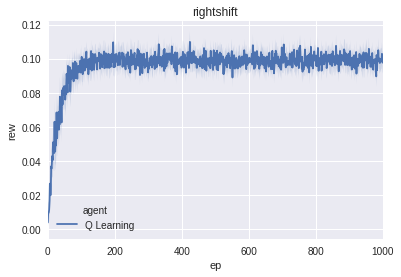

In [47]:
run_fn(rightshift, eps=1000)

In [ ]:
run_fn(sorting, eps=1000)